In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import sys, os
sys.path.append('C:\\Users\Quentin\\Documents\\ALMA_CHILI\\gaia-shock\\src')

## directory
rootdir = r'C:\Users\Quentin\Documents\ALMA_CHILI'
wdir    = r'%s\products'%(rootdir)
#notedir = r'%s\gaia-shock\notebooks_Quentin'%(rootdir)

os.chdir(wdir)  # to change the current directory
import gaia_utils_quentin as gu

with open('ilabel_dbscan', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    file_result = my_depickler.load()

In [2]:
voname_list = ["NGC2682-4.0deg-0.2err.vot", "NGC2516-3.5deg-0.2err.vot","NGC6811-1.0deg-0.2err.vot"]
tab_source = []
tab_ilabel = []
for voname in voname_list :
    source = gu.source()
    source.read_votable(voname)
    source.convert_filter_data()
    source.convert_to_cartesian()
    tab_source.append(source)
    
    ilabel = file_result[source.name]['ilabel']
    tab_ilabel.append(ilabel)

## NGC2682-4.0deg-0.2err.vot read...
## Total stars: 46444
## Density star per pc^3: 0.00413

## Conversion done...
## Stars selected: 45802
## NGC2516-3.5deg-0.2err.vot read...
## Total stars: 45520
## Density star per pc^3: 0.02270

## Conversion done...
## Stars selected: 44723
## NGC6811-1.0deg-0.2err.vot read...
## Total stars: 12084
## Density star per pc^3: 0.00925

## Conversion done...
## Stars selected: 11886


mean Dist: 413.1,    2309 stars


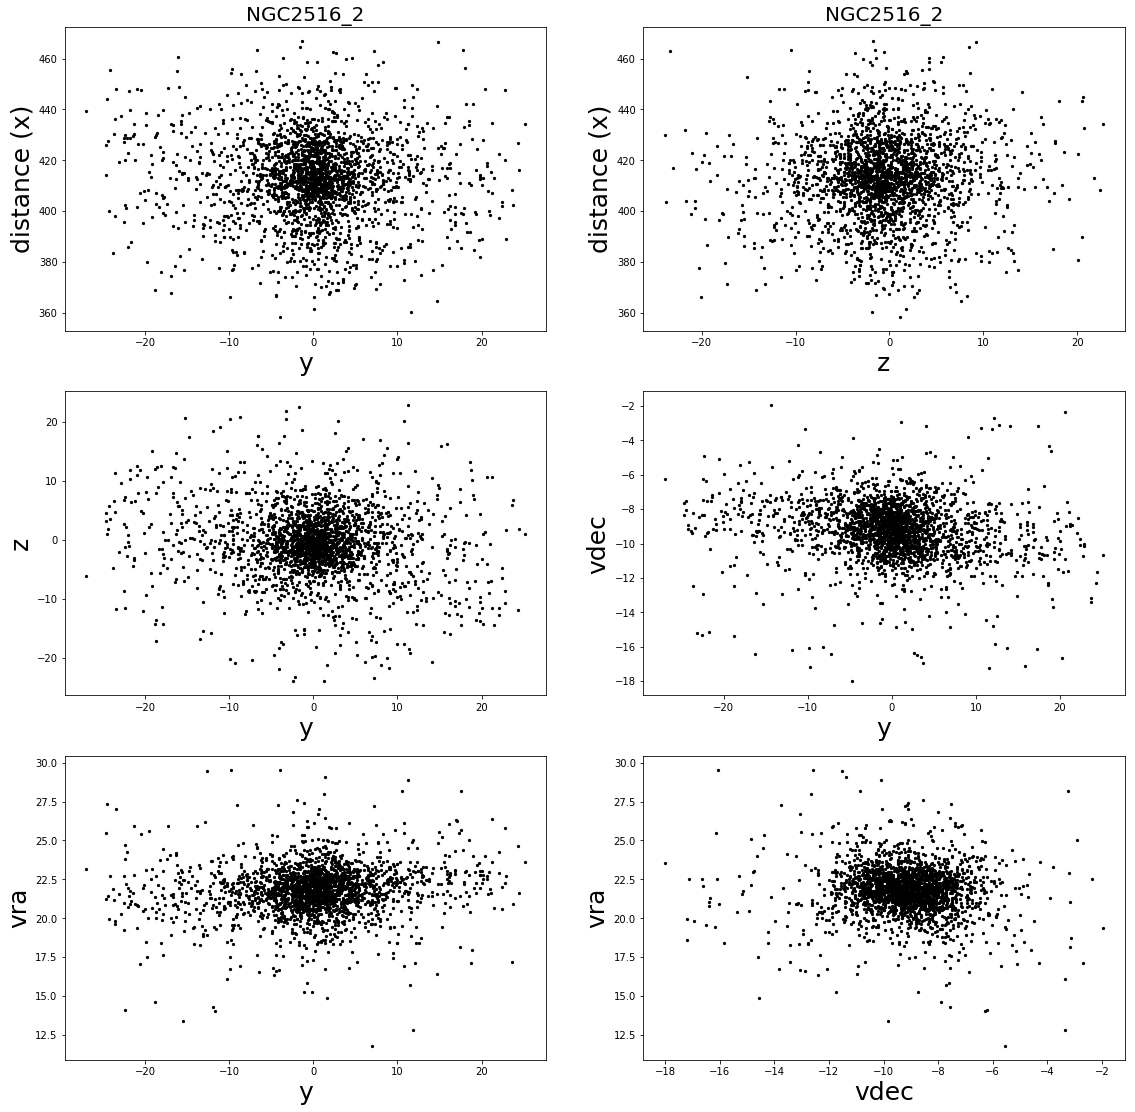

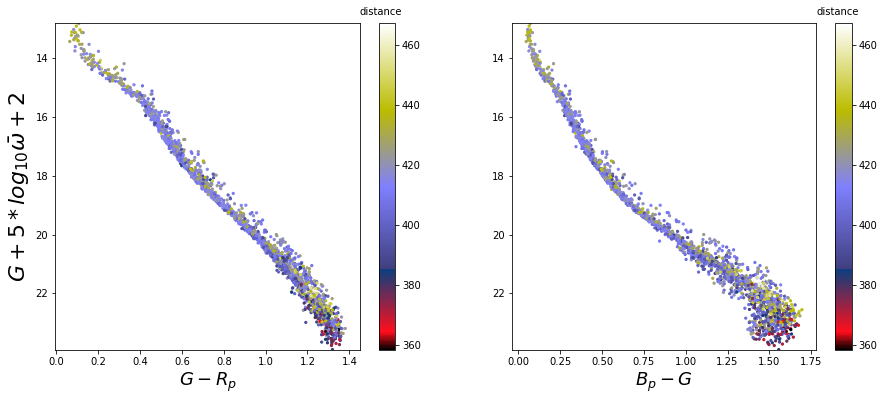

In [2]:
tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC6811"]
name = tab_name[2]

print("mean Dist: %5.1f,    %d stars"%(np.mean(file_result[name]['data_cart'][:,0]),len(file_result[name]['data_cart'])))
gu.plot_information_cluster(file_result[name]['data_cart'], size=5, cartesian=True, HRD=True, title=name)


In [15]:
#tab_source[0].plot_information(0.01,True, HRD=True, ilabel=tab_ilabel[0])
#tab_source[0].plot_3D(0.01,True,(0,6,5),ilabel=tab_ilabel[0])
#gu.HRD_cluster(source.df,size=0.3)
#gu.HRD_cluster(source.df[ilabel,:],size=0.8)

In [4]:
def get_maxmin_index(mag, percentage = 10) :
    "Select max and min 'percentage'% index of mag array"
    list_mag = []
    for i in range(len(mag)) :
        list_mag.append([mag[i],i])
    tab_index = np.array(sorted(list_mag)).astype(int)[:,1]

    # Select index magnitude for min and max
    imin_mag = tab_index[:int(percentage/100*len(mag))]
    imax_mag = tab_index[-int(percentage/100*len(mag)):]
    
    return imin_mag, imax_mag

In [23]:
tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC6811"]
name = tab_name[1]
data = file_result[name]['data_cart']
print(len(data))

imin_mag, imax_mag = get_maxmin_index(data[:,5], percentage = 50)

2801


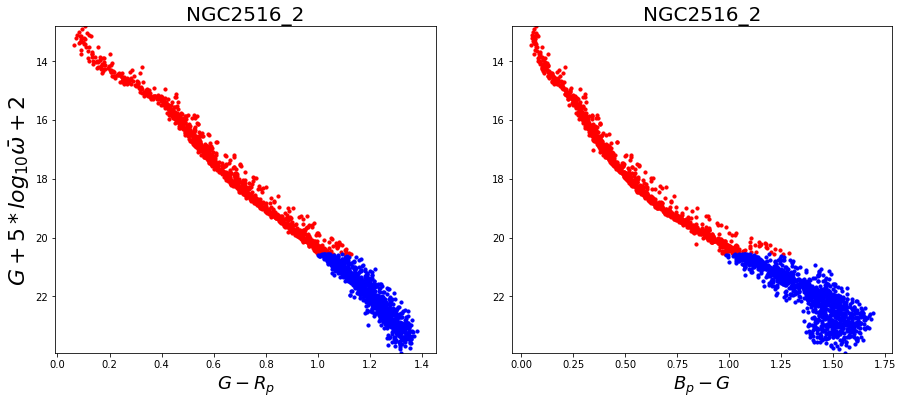

In [11]:
plt.figure(figsize=(15,6))
G_max = np.max(data[:,5])
G_min = np.min(data[:,5])
for i in (6,7) :
    plt.subplot(1,2,i-5)
    plt.ylim(G_max, G_min)
    plt.title(name, fontsize=20)
    plt.scatter(data[:,i], data[:,5], s=1, c='k')
    plt.scatter(data[imin_mag,i], data[imin_mag,5], s=10, c='r')
    plt.scatter(data[imax_mag,i], data[imax_mag,5], s=10, c='b')
    plt.xlabel(gu.data_name[i], fontsize=18)
    if i == 6 : plt.ylabel(gu.data_name[5], fontsize=22)
plt.show()

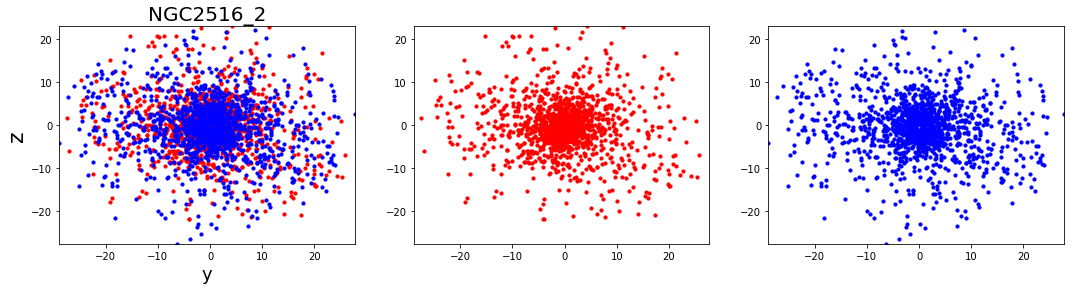

In [30]:
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.title(name, fontsize=20)
plt.scatter(data[:,1], data[:,2], s=1, c='k')
plt.scatter(data[imin_mag,1], data[imin_mag,2], s=10, c='r')
plt.scatter(data[imax_mag,1], data[imax_mag,2], s=10, c='b')
plt.xlabel(gu.data_name_cart[1], fontsize=18)
plt.ylabel(gu.data_name_cart[2], fontsize=22)
plt.xlim(min(data[:,1]),max(data[:,1]))
plt.ylim(min(data[:,2]),max(data[:,2]))
plt.subplot(132)
plt.xlim(min(data[:,1]),max(data[:,1]))
plt.ylim(min(data[:,2]),max(data[:,2]))
plt.scatter(data[imin_mag,1], data[imin_mag,2], s=10, c='r')
plt.subplot(133)
plt.xlim(min(data[:,1]),max(data[:,1]))
plt.ylim(min(data[:,2]),max(data[:,2]))
plt.scatter(data[imax_mag,1], data[imax_mag,2], s=10, c='b')
plt.show()

In [13]:
print("std(y)   std(z)  std(z)/std(y)")
print("%2.2f      %.2f       %.2f"%(np.std(data[imin_mag,1]),np.std(data[imin_mag,2]),np.std(data[imin_mag,2])/np.std(data[imin_mag,1])))

print("%2.2f      %.2f       %.2f"%(np.std(data[imax_mag,1]),np.std(data[imax_mag,2]),np.std(data[imax_mag,2])/np.std(data[imax_mag,1])))

std(y)   std(z)  std(z)/std(y)
6.88      5.71       0.83
8.16      6.26       0.77


In [14]:
print("std(y)   std(x)  std(x)/std(y)")
print("%2.2f      %.2f       %.2f"%(np.std(data[imin_mag,1]),np.std(data[imin_mag,0]),np.std(data[imin_mag,0])/np.std(data[imin_mag,1])))

print("%2.2f      %.2f       %.2f"%(np.std(data[imax_mag,1]),np.std(data[imax_mag,0]),np.std(data[imax_mag,0])/np.std(data[imax_mag,1])))

std(y)   std(x)  std(x)/std(y)
6.88      10.39       1.51
8.16      20.44       2.51


In [33]:
tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC6811"]
name = tab_name[1]
data = file_result[name]['data_cart']
print(len(data))

imin_mag, imax_mag = get_maxmin_index(data[:,5], percentage = 50)
print("std(y)   std(z)  std(z)/std(y)")
print("%2.2f      %.2f       %.2f"%(np.std(data[imin_mag,1]),np.std(data[imin_mag,2]),np.std(data[imin_mag,2])/np.std(data[imin_mag,1])))
print("%2.2f      %.2f       %.2f"%(np.std(data[imax_mag,1]),np.std(data[imax_mag,2]),np.std(data[imax_mag,2])/np.std(data[imax_mag,1])))

print("std(y)   std(x)  std(x)/std(y)")
print("%2.2f      %.2f       %.2f"%(np.std(data[imin_mag,1]),np.std(data[imin_mag,0]),np.std(data[imin_mag,0])/np.std(data[imin_mag,1])))
print("%2.2f      %.2f       %.2f"%(np.std(data[imax_mag,1]),np.std(data[imax_mag,0]),np.std(data[imax_mag,0])/np.std(data[imax_mag,1])))



tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC6811"]
name = tab_name[2]
data = file_result[name]['data_cart']
print(len(data))

imin_mag, imax_mag = get_maxmin_index(data[:,5], percentage = 50)
print("std(y)   std(z)  std(z)/std(y)")
print("%2.2f      %.2f       %.2f"%(np.std(data[imin_mag,1]),np.std(data[imin_mag,2]),np.std(data[imin_mag,2])/np.std(data[imin_mag,1])))
print("%2.2f      %.2f       %.2f"%(np.std(data[imax_mag,1]),np.std(data[imax_mag,2]),np.std(data[imax_mag,2])/np.std(data[imax_mag,1])))

print("std(y)   std(x)  std(x)/std(y)")
print("%2.2f      %.2f       %.2f"%(np.std(data[imin_mag,1]),np.std(data[imin_mag,0]),np.std(data[imin_mag,0])/np.std(data[imin_mag,1])))
print("%2.2f      %.2f       %.2f"%(np.std(data[imax_mag,1]),np.std(data[imax_mag,0]),np.std(data[imax_mag,0])/np.std(data[imax_mag,1])))

2801
std(y)   std(z)  std(z)/std(y)
5.32      4.57       0.86
5.64      4.53       0.80
std(y)   std(x)  std(x)/std(y)
5.32      11.62       2.18
5.64      29.07       5.15
2309
std(y)   std(z)  std(z)/std(y)
6.88      5.71       0.83
8.16      6.26       0.77
std(y)   std(x)  std(x)/std(y)
6.88      10.39       1.51
8.16      20.44       2.51


## --------------------------------------------------------
### 2D Cluster Density

In [15]:
def volume(r) :
    return np.pi*r**2
    #return 4/3*np.pi*r**3

In [16]:
def cart_to_polar(data, center) :
    r = np.sqrt((data[:,1]-center[0])**2 + (data[:,2]-center[1])**2)
    theta = np.arctan((data[:,2]-center[1])/(data[:,1]-center[0]))
    return np.array([r, theta]).T

In [17]:
def lissage(x,y,p):
    "smoothing y data computing the Moving average"
    Lyout=[]; Lxout = np.copy(x[p: -p])
    for index in range(p, len(y)-p):
        Lyout.append(np.mean(y[index-p : index+p+1]))
    return Lxout,Lyout

In [18]:
def radius_density(data_polar, radius_range, index) :
    density = np.zeros(len(radius_range))
    r_previous = radius_range[0]
    for i, r in enumerate(radius_range[1:]) :
        density[i] = len(np.where((data_polar[index,0] < r) & (data_polar[index,0] >= r_previous))[0]) / (volume(r)-volume(r_previous))
        r_previous = r
    return density

In [19]:
def density_curve(data, name, percentage = 10, smoothing = 0) :

    imin_mag, imax_mag = get_maxmin_index(data[:,5], percentage)
    center = [np.mean(data[:,1]),np.mean(data[:,2])]
    data_polar = cart_to_polar(data, center)

    radius_range_def = np.linspace(np.min(data_polar[:,0]),np.max(data_polar[:,0]),150)
    density = radius_density(data_polar, radius_range_def, np.arange(len(data_polar)))
    density_min = radius_density(data_polar, radius_range_def, imin_mag)
    density_max = radius_density(data_polar, radius_range_def, imax_mag)

    if smoothing != 0 :  
        radius_range, density = lissage(radius_range_def,density, smoothing)
        density_min = lissage(radius_range_def,density_min, smoothing)[1]
        density_max = lissage(radius_range_def,density_max, smoothing)[1]
    else :
        radius_range = radius_range_def

    plt.figure(figsize=(17,4))
    plt.plot(radius_range,density,c='k', label="complete cluster")
    plt.plot(radius_range,density_min,c='r', label='%s%% MIN mag'%percentage)
    plt.plot(radius_range,density_max,c='b', label='%s%% MAX mag'%percentage)
    plt.title("%s density"%name, fontsize = 18)
    plt.xlabel("Radius $r$ from the cluster center", fontsize = 18)
    plt.ylabel(r"Density $\frac{stars}{pc^2}$", fontsize = 18)
    plt.legend(loc='best',fontsize=16)
    plt.yscale('log')
    #plt.xscale('log')
    plt.show()

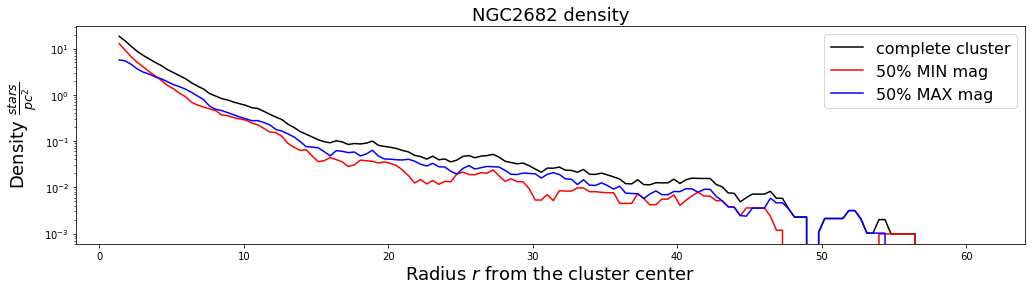

In [21]:
tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC6811"]
name = tab_name[0]
data = file_result[name]['data_cart']
percentage = 50

imin_mag, imax_mag = get_maxmin_index(data[:,5], percentage)

density_curve(data, name, percentage, smoothing = 3)

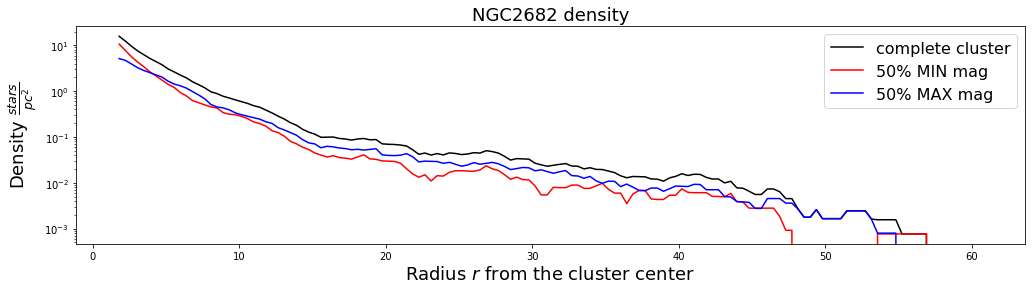

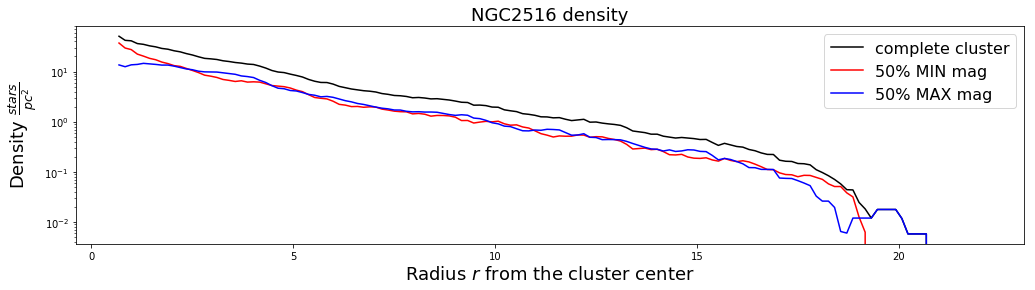

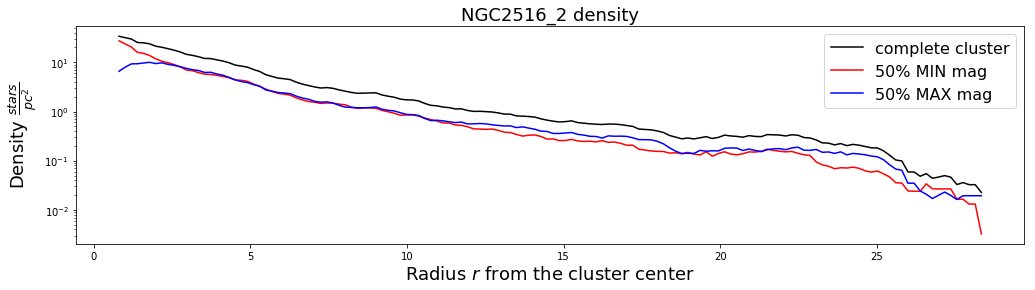

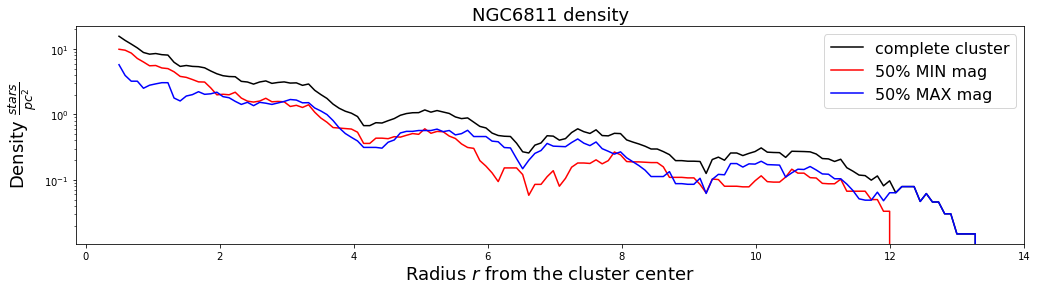

In [31]:
percentage = 50

for name in tab_name :
    data = file_result[name]['data_cart']
    density_curve(data, name, percentage, smoothing = 4)